In [1]:
#This project goes over a Logistic Regression analysis to predict employee turnover while I was completing my Masters at Georgetown University in my Machine Learning 1 class. I received a 99/100 on the project and there is a written report that goes into more detail about my analysis.

In [2]:
###LIBRARY FOR PACKAGES###
library(tidyverse)
library(ggplot2)
library(PerformanceAnalytics)
library(lmtest)
library(corrr)
library(reshape2)
library(plotly)
library(zoom)
library(ggforce)
library(caret)
library(sandwich)
library(Metrics)
library(hablar)
library(ROSE)
library(prediction)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



######################### Warning from 'xts' package ##########################
#                                                                             #
# The dplyr lag() function breaks how base R's lag() function is supposed to  #
# work, which breaks lag(my_xts). Calls to lag(my_xts) that

In [3]:
#I also used the packages 'Hmisc' and 'car' for multicollinearity (vif function) and reviewing all of the P-values.
#These packages are no longer supported by R or Kaggle even after trying it through githubinstall.
#I have commented out those lines of code to make the notebook run and it does not affect the overall outcome of the project because P-values are seen in the model summaries and I provide comments for the multicollinearity analysis.

In [4]:
install.packages('readxl')
library(readxl)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
canterra = read_excel("/kaggle/input/employee-data/Employee_Data_Project.xlsx")

In [6]:
###GETTING TO KNOW THE DATA AND WHAT I AM WORKING WITH AND SPLITTING THE DATA###
###I USED EXAMPLE 2 FROM WEEK 4 SLIDES FOR CODING AND STEPS###

dim(canterra)
summary(canterra)

[1] 4410   18

      Age         Attrition         BusinessTravel     DistanceFromHome
 Min.   :18.00   Length:4410        Length:4410        Min.   : 1.000  
 1st Qu.:30.00   Class :character   Class :character   1st Qu.: 2.000  
 Median :36.00   Mode  :character   Mode  :character   Median : 7.000  
 Mean   :36.92                                         Mean   : 9.193  
 3rd Qu.:43.00                                         3rd Qu.:14.000  
 Max.   :60.00                                         Max.   :29.000  
   Education       EmployeeID      Gender             JobLevel    
 Min.   :1.000   Min.   :   1   Length:4410        Min.   :1.000  
 1st Qu.:2.000   1st Qu.:1103   Class :character   1st Qu.:1.000  
 Median :3.000   Median :2206   Mode  :character   Median :2.000  
 Mean   :2.913   Mean   :2206                      Mean   :2.064  
 3rd Qu.:4.000   3rd Qu.:3308                      3rd Qu.:3.000  
 Max.   :5.000   Max.   :4410                      Max.   :5.000  
 MaritalStatus          Inc

In [7]:
#Splitting data into training and test (70:30)
set.seed(123) #for reproducibility
index = createDataPartition(canterra$Attrition, p = 0.7, list = FALSE) #Create split, any column is fine

train = canterra[index, ]
train$Attrition[train$Attrition == "No"] = 0
train$Attrition[train$Attrition == "Yes"] = 1

train = train %>%
  mutate(TotalWorkingYears = as.numeric(TotalWorkingYears),
         JobSatisfaction = as.numeric(JobSatisfaction),
         NumCompaniesWorked = as.numeric(NumCompaniesWorked),
         EnvironmentSatisfaction = as.numeric(EnvironmentSatisfaction),
         Attrition = as.numeric(Attrition)) %>%
  mutate(BusinessTravel = as.factor(BusinessTravel),
         JobLevel = as.factor(JobLevel),
         MaritalStatus = as.factor(MaritalStatus),
         Gender = as.factor(Gender),
         Education = as.factor(Education))


test = canterra[-index, ]
test$Attrition[test$Attrition == "No"] = 0
test$Attrition[test$Attrition == "Yes"] = 1

test = test %>%
  mutate(TotalWorkingYears = as.numeric(TotalWorkingYears),
         JobSatisfaction = as.numeric(JobSatisfaction),
         NumCompaniesWorked = as.numeric(NumCompaniesWorked),
         EnvironmentSatisfaction = as.numeric(EnvironmentSatisfaction),
         Attrition = as.numeric(Attrition)) %>%
  mutate(BusinessTravel = as.factor(BusinessTravel),
         JobLevel = as.factor(JobLevel),
         MaritalStatus = as.factor(MaritalStatus),
         Gender = as.factor(Gender),
         Education = as.numeric(Education))

Warning message:
“There were 4 warnings in `mutate()`.
The first warning was:
ℹ In argument: `TotalWorkingYears = as.numeric(TotalWorkingYears)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 3 remaining warnings.”
Warning message:
“There were 4 warnings in `mutate()`.
The first warning was:
ℹ In argument: `TotalWorkingYears = as.numeric(TotalWorkingYears)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 3 remaining warnings.”


In [8]:
#CHECKING FOR MISSING VALUES#

sapply(train, function(x)sum(is.na(x)))
train$NumCompaniesWorked[is.na(train$NumCompaniesWorked)] = median(train$NumCompaniesWorked, na.rm = TRUE)
train$TotalWorkingYears[is.na(train$TotalWorkingYears)] = median(train$TotalWorkingYears, na.rm = TRUE)
train$EnvironmentSatisfaction[is.na(train$EnvironmentSatisfaction)] = median(train$EnvironmentSatisfaction, na.rm = TRUE)
train$JobSatisfaction[is.na(train$JobSatisfaction)] = mean(train$JobSatisfaction, na.rm = TRUE)
       
sapply(train, function(x)sum(is.na(x)))

Age               Attrition          BusinessTravel 
                      0                       0                       0 
       DistanceFromHome               Education              EmployeeID 
                      0                       0                       0 
                 Gender                JobLevel           MaritalStatus 
                      0                       0                       0 
                 Income      NumCompaniesWorked           StandardHours 
                      0                      12                       0 
      TotalWorkingYears   TrainingTimesLastYear          YearsAtCompany 
                      7                       0                       0 
   YearsWithCurrManager EnvironmentSatisfaction         JobSatisfaction 
                      0                      14                      16

Age               Attrition          BusinessTravel 
                      0                       0                       0 
       DistanceFromHome               Education              EmployeeID 
                      0                       0                       0 
                 Gender                JobLevel           MaritalStatus 
                      0                       0                       0 
                 Income      NumCompaniesWorked           StandardHours 
                      0                       0                       0 
      TotalWorkingYears   TrainingTimesLastYear          YearsAtCompany 
                      0                       0                       0 
   YearsWithCurrManager EnvironmentSatisfaction         JobSatisfaction 
                      0                       0                       0

In [9]:
sapply(test, function(x)sum(is.na(x)))
test$NumCompaniesWorked[is.na(test$NumCompaniesWorked)] = median(test$NumCompaniesWorked, na.rm = TRUE)
test$TotalWorkingYears[is.na(test$TotalWorkingYears)] = median(test$TotalWorkingYears, na.rm = TRUE)
test$EnvironmentSatisfaction[is.na(test$EnvironmentSatisfaction)] = mean(test$EnvironmentSatisfaction, na.rm = TRUE)
test$JobSatisfaction[is.na(test$JobSatisfaction)] = median(test$JobSatisfaction, na.rm = TRUE)
       
sapply(test, function(x)sum(is.na(x)))
#WE SHOULD NOW HAVE NO MISSING VALUES#

Age               Attrition          BusinessTravel 
                      0                       0                       0 
       DistanceFromHome               Education              EmployeeID 
                      0                       0                       0 
                 Gender                JobLevel           MaritalStatus 
                      0                       0                       0 
                 Income      NumCompaniesWorked           StandardHours 
                      0                       7                       0 
      TotalWorkingYears   TrainingTimesLastYear          YearsAtCompany 
                      2                       0                       0 
   YearsWithCurrManager EnvironmentSatisfaction         JobSatisfaction 
                      0                      11                       4

Age               Attrition          BusinessTravel 
                      0                       0                       0 
       DistanceFromHome               Education              EmployeeID 
                      0                       0                       0 
                 Gender                JobLevel           MaritalStatus 
                      0                       0                       0 
                 Income      NumCompaniesWorked           StandardHours 
                      0                       0                       0 
      TotalWorkingYears   TrainingTimesLastYear          YearsAtCompany 
                      0                       0                       0 
   YearsWithCurrManager EnvironmentSatisfaction         JobSatisfaction 
                      0                       0                       0

In [10]:
train = train %>%
  select(-c(EmployeeID, StandardHours))

summary(train)

test = test %>%
  select(-c(EmployeeID, StandardHours))

summary(test)

      Age          Attrition                BusinessTravel DistanceFromHome
 Min.   :18.00   Min.   :0.0000   Non-Travel       : 315   Min.   : 1.000  
 1st Qu.:30.00   1st Qu.:0.0000   Travel_Frequently: 587   1st Qu.: 2.000  
 Median :36.00   Median :0.0000   Travel_Rarely    :2186   Median : 7.000  
 Mean   :36.99   Mean   :0.1613                            Mean   : 9.004  
 3rd Qu.:43.00   3rd Qu.:0.0000                            3rd Qu.:13.000  
 Max.   :60.00   Max.   :1.0000                            Max.   :29.000  
 Education    Gender     JobLevel  MaritalStatus      Income      
 1: 350    Female:1256   1:1129   Divorced: 698   Min.   : 10090  
 2: 601    Male  :1832   2:1133   Married :1417   1st Qu.: 29110  
 3:1205                  3: 463   Single  : 973   Median : 48980  
 4: 830                  4: 219                   Mean   : 64509  
 5: 102                  5: 144                   3rd Qu.: 82240  
                                                  Max.   :199990  

      Age          Attrition                BusinessTravel DistanceFromHome
 Min.   :18.00   Min.   :0.0000   Non-Travel       :135    Min.   : 1.000  
 1st Qu.:30.00   1st Qu.:0.0000   Travel_Frequently:244    1st Qu.: 2.000  
 Median :36.00   Median :0.0000   Travel_Rarely    :943    Median : 7.000  
 Mean   :36.77   Mean   :0.1611                            Mean   : 9.634  
 3rd Qu.:43.00   3rd Qu.:0.0000                            3rd Qu.:15.000  
 Max.   :60.00   Max.   :1.0000                            Max.   :29.000  
   Education        Gender    JobLevel  MaritalStatus     Income      
 Min.   :1.000   Female:508   1:500    Divorced:283   Min.   : 10510  
 1st Qu.:2.000   Male  :814   2:469    Married :602   1st Qu.: 29110  
 Median :3.000                3:191    Single  :437   Median : 50065  
 Mean   :2.911                4: 99                   Mean   : 66245  
 3rd Qu.:4.000                5: 63                   3rd Qu.: 84935  
 Max.   :5.000                            

In [11]:
#STEP 3: DOWNSAMPLING (Make sure you install "ROSE" package)

data_balanced_under = ovun.sample(formula = Attrition ~ ., data = train, method = "under", p = 0.5)$data #in her slides she did a 60/40 (N=60% of training observations)
table(data_balanced_under$Attrition)


  0   1 
487 498 

In [12]:
#TRYING OUT THE OTHER DOWNSAMPLING#

data_balanced_over = ovun.sample(formula = Attrition ~ ., data = train, method = "over", p = 0.5)$data
data_balanced_both = ovun.sample(formula = Attrition ~ ., data = train, method = "both", N= nrow(train), p = 0.5)$data
data_balanced_rose = ROSE(formula = Attrition ~ ., data = train, p = 0.5)$data

glm(Attrition ~ ., data = data_balanced_under, family = binomial)
glm(Attrition ~ ., data = data_balanced_over, family = binomial)
glm(Attrition ~ ., data = data_balanced_both, family = binomial)
glm(Attrition ~ ., data = data_balanced_rose, family = binomial)


Call:  glm(formula = Attrition ~ ., family = binomial, data = data_balanced_under)

Coefficients:
                    (Intercept)                              Age  
                      1.567e+00                       -1.566e-02  
BusinessTravelTravel_Frequently      BusinessTravelTravel_Rarely  
                      1.369e+00                        6.399e-01  
               DistanceFromHome                       Education2  
                     -4.867e-04                        9.118e-02  
                     Education3                       Education4  
                     -4.278e-01                       -1.799e-01  
                     Education5                       GenderMale  
                     -2.851e-01                        2.219e-01  
                      JobLevel2                        JobLevel3  
                      1.540e-01                       -1.299e-01  
                      JobLevel4                        JobLevel5  
                     -3.383e-0


Call:  glm(formula = Attrition ~ ., family = binomial, data = data_balanced_over)

Coefficients:
                    (Intercept)                              Age  
                      1.053e+00                       -2.451e-02  
BusinessTravelTravel_Frequently      BusinessTravelTravel_Rarely  
                      1.452e+00                        8.124e-01  
               DistanceFromHome                       Education2  
                      4.528e-03                        2.194e-01  
                     Education3                       Education4  
                      2.829e-02                        1.350e-01  
                     Education5                       GenderMale  
                     -2.881e-01                        2.269e-01  
                      JobLevel2                        JobLevel3  
                      1.929e-01                       -1.939e-01  
                      JobLevel4                        JobLevel5  
                      1.589e-01


Call:  glm(formula = Attrition ~ ., family = binomial, data = data_balanced_both)

Coefficients:
                    (Intercept)                              Age  
                      1.619e+00                       -2.613e-02  
BusinessTravelTravel_Frequently      BusinessTravelTravel_Rarely  
                      1.591e+00                        9.420e-01  
               DistanceFromHome                       Education2  
                     -4.275e-03                        1.331e-01  
                     Education3                       Education4  
                     -1.037e-01                        6.654e-02  
                     Education5                       GenderMale  
                     -3.729e-01                        6.810e-02  
                      JobLevel2                        JobLevel3  
                      9.963e-02                       -1.567e-01  
                      JobLevel4                        JobLevel5  
                     -9.560e-02


Call:  glm(formula = Attrition ~ ., family = binomial, data = data_balanced_rose)

Coefficients:
                    (Intercept)                              Age  
                      7.931e-01                       -1.667e-02  
BusinessTravelTravel_Frequently      BusinessTravelTravel_Rarely  
                      1.426e+00                        7.682e-01  
               DistanceFromHome                       Education2  
                     -1.640e-03                        1.123e-01  
                     Education3                       Education4  
                     -3.544e-01                       -1.900e-01  
                     Education5                       GenderMale  
                     -3.615e-01                        2.632e-01  
                      JobLevel2                        JobLevel3  
                      1.589e-01                        5.107e-02  
                      JobLevel4                        JobLevel5  
                      5.218e-01

In [13]:
#LOGISTIC REGRESSION MODEL#

Logistic_model_1 = glm(Attrition ~ ., data = train, family = binomial) #This is an all encompassing model which is why my data is the training set
Logistic_model_2 = glm(Attrition ~ JobSatisfaction + TotalWorkingYears, data = data_balanced_under, family = binomial) #Question 1 Tasking
Logistic_model_3 = glm(Attrition ~ Gender + Education + Age, data = data_balanced_under, family = binomial) #Last part of Question 1 Tasking
Logistic_model_4 = glm(Attrition ~ Gender + Education + Age + JobSatisfaction + TotalWorkingYears, data = data_balanced_under, family = binomial)

summary(Logistic_model_1)
summary(Logistic_model_2)
summary(Logistic_model_3)
summary(Logistic_model_4)


Call:
glm(formula = Attrition ~ ., family = binomial, data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4587  -0.6165  -0.4107  -0.2363   2.8313  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      2.571e-01  4.736e-01   0.543  0.58717    
Age                             -2.409e-02  8.242e-03  -2.923  0.00346 ** 
BusinessTravelTravel_Frequently  1.406e+00  2.444e-01   5.752 8.80e-09 ***
BusinessTravelTravel_Rarely      7.307e-01  2.289e-01   3.192  0.00141 ** 
DistanceFromHome                -8.385e-04  6.788e-03  -0.124  0.90169    
Education2                       1.320e-02  1.969e-01   0.067  0.94656    
Education3                      -2.252e-01  1.810e-01  -1.244  0.21354    
Education4                      -1.271e-01  1.888e-01  -0.673  0.50093    
Education5                      -4.863e-01  3.422e-01  -1.421  0.15531    
GenderMale                       9.216e-02  1.089e-0


Call:
glm(formula = Attrition ~ JobSatisfaction + TotalWorkingYears, 
    family = binomial, data = data_balanced_under)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.684  -1.137   0.745   1.065   2.303  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        1.501239   0.200159   7.500 6.37e-14 ***
JobSatisfaction   -0.288243   0.059998  -4.804 1.55e-06 ***
TotalWorkingYears -0.073174   0.009836  -7.440 1.01e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1365.4  on 984  degrees of freedom
Residual deviance: 1278.7  on 982  degrees of freedom
AIC: 1284.7

Number of Fisher Scoring iterations: 4



Call:
glm(formula = Attrition ~ Gender + Education + Age, family = binomial, 
    data = data_balanced_under)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.6091  -1.1547   0.7552   1.1051   1.7159  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.590326   0.329107   4.832 1.35e-06 ***
GenderMale   0.173926   0.133860   1.299    0.194    
Education2   0.195974   0.249776   0.785    0.433    
Education3  -0.202581   0.225873  -0.897    0.370    
Education4  -0.114943   0.236651  -0.486    0.627    
Education5  -0.007432   0.436059  -0.017    0.986    
Age         -0.044815   0.007189  -6.234 4.54e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1365.4  on 984  degrees of freedom
Residual deviance: 1318.2  on 978  degrees of freedom
AIC: 1332.2

Number of Fisher Scoring iterations: 4



Call:
glm(formula = Attrition ~ Gender + Education + Age + JobSatisfaction + 
    TotalWorkingYears, family = binomial, data = data_balanced_under)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.7692  -1.1115   0.6953   1.0702   2.2236  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        1.740084   0.383548   4.537 5.71e-06 ***
GenderMale         0.169469   0.136889   1.238    0.216    
Education2         0.185344   0.254881   0.727    0.467    
Education3        -0.219268   0.230767  -0.950    0.342    
Education4        -0.046955   0.242057  -0.194    0.846    
Education5         0.007422   0.444097   0.017    0.987    
Age               -0.010039   0.009777  -1.027    0.305    
JobSatisfaction   -0.291114   0.060726  -4.794 1.64e-06 ***
TotalWorkingYears -0.064070   0.013031  -4.917 8.81e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 

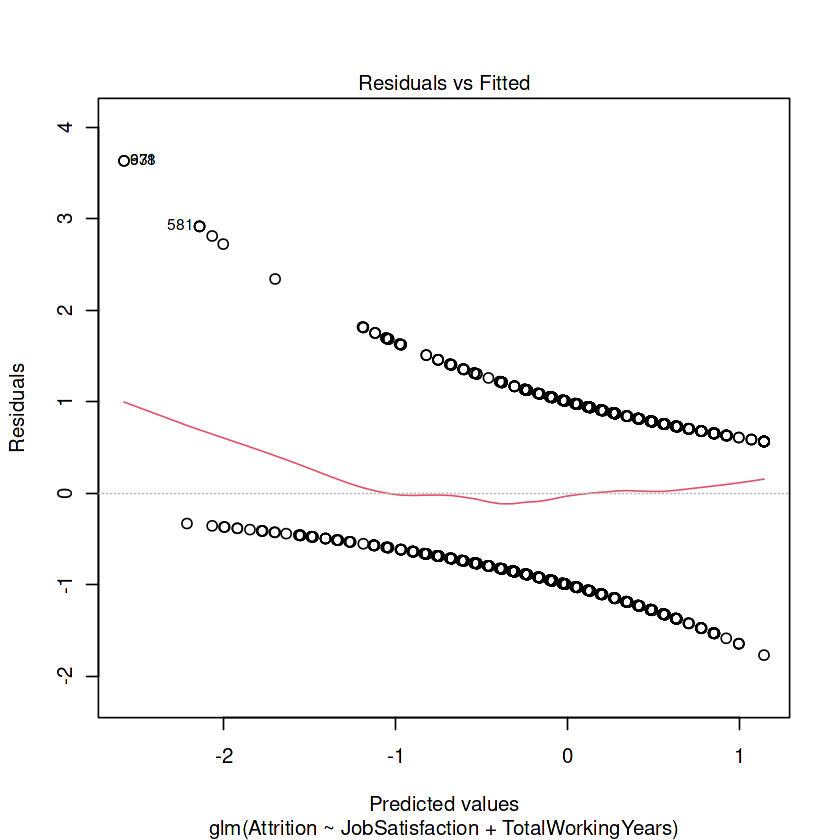

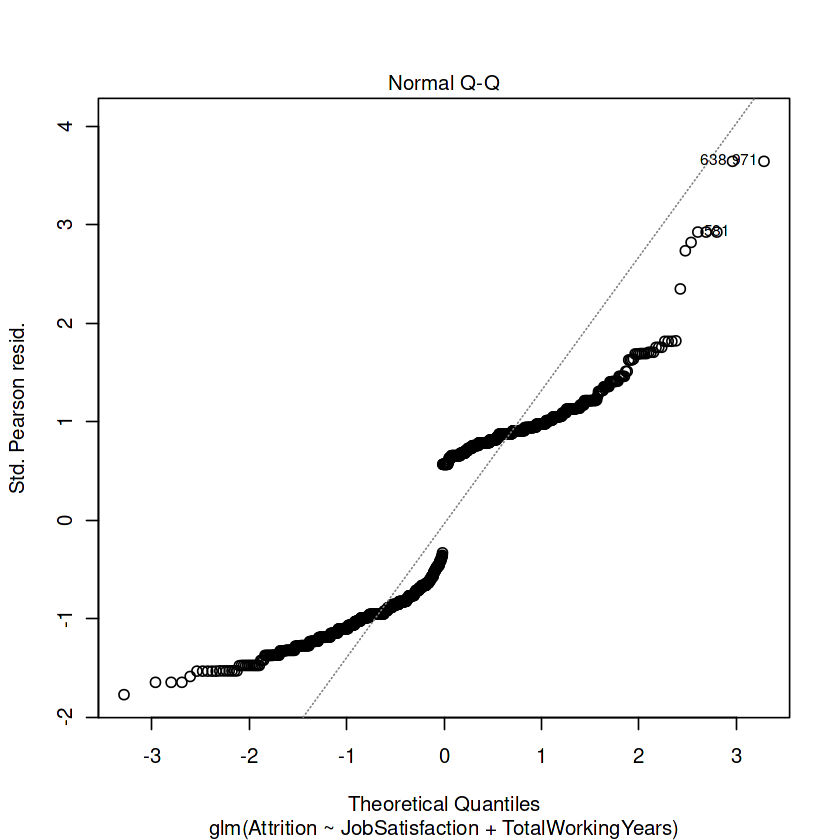

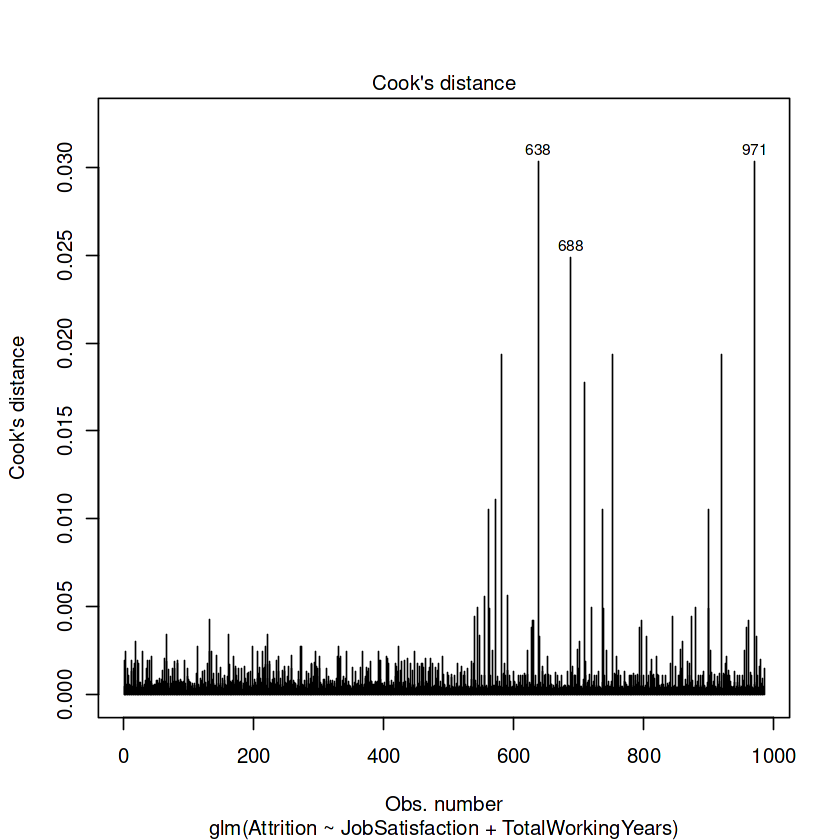

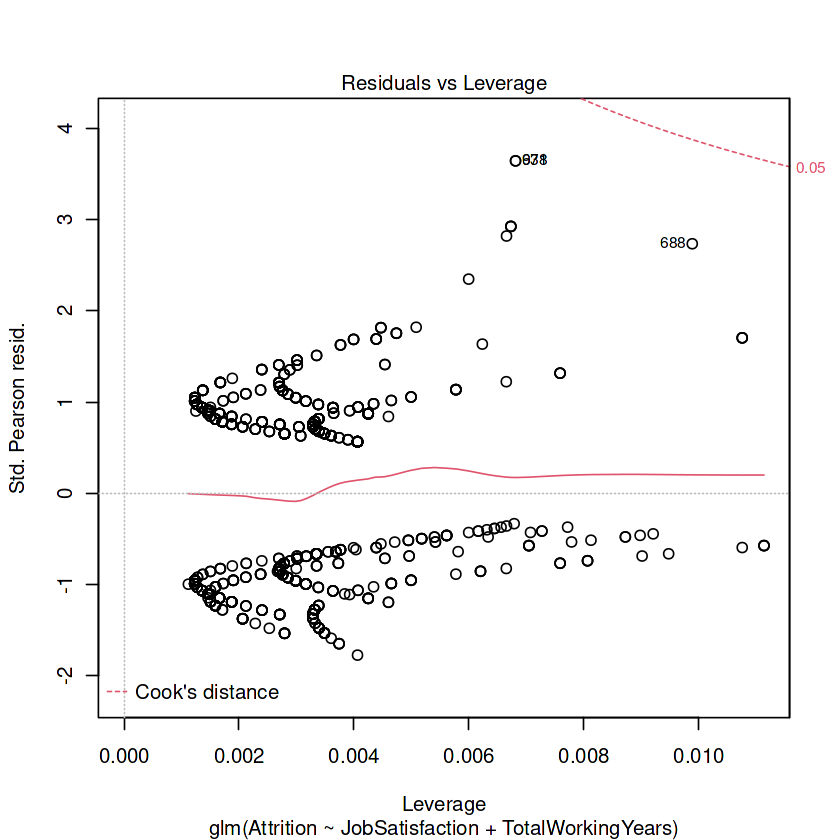

In [14]:
#REMOVING OUTLIERS, FOR THE FINAL MODEL#

lapply(c(1, 2, 4, 5), #showing 4 types of plots
       function(x) plot(Logistic_model_2,
                        which = x,
                        # labels.id = 1:nrow(train) IDK WHY THERE IS A HASHTAG ON THIS LINE BUT IF YOU TAKE IT AWAY IT CHANGES OUTLIERS (SHE HAD # IN HER SLIDES),
                        cook.levels = c(0.05, 0.1))) %>% invisible()
#418, 475, 808, 525 are outliers

to.rm = c(418, 475, 808, 525)
train = train[-to.rm, ]
test = test[-to.rm, ]

In [15]:
#CHECKING WHICH DOWNSAMPLE WORKS BEST, LOWER AIC = BETTER#

oversample_model = glm(Attrition ~ ., data = data_balanced_over, family = binomial)
summary(oversample_model)

undersample_model = glm(Attrition ~ ., data = data_balanced_under, family = binomial)
summary(undersample_model) 

both_sample_model = glm(Attrition ~ ., data = data_balanced_both, family = binomial)
summary(both_sample_model) 

rose_sample_model = glm(Attrition ~ ., data = data_balanced_rose, family = binomial)
summary(rose_sample_model) 


Call:
glm(formula = Attrition ~ ., family = binomial, data = data_balanced_over)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2016  -0.9677  -0.2682   0.9751   1.9939  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      1.053e+00  2.634e-01   3.999 6.37e-05 ***
Age                             -2.451e-02  4.704e-03  -5.209 1.90e-07 ***
BusinessTravelTravel_Frequently  1.452e+00  1.339e-01  10.848  < 2e-16 ***
BusinessTravelTravel_Rarely      8.124e-01  1.217e-01   6.677 2.44e-11 ***
DistanceFromHome                 4.528e-03  4.053e-03   1.117 0.263812    
Education2                       2.194e-01  1.214e-01   1.807 0.070785 .  
Education3                       2.829e-02  1.106e-01   0.256 0.798184    
Education4                       1.350e-01  1.160e-01   1.164 0.244417    
Education5                      -2.881e-01  2.072e-01  -1.390 0.164379    
GenderMale                       2.269e


Call:
glm(formula = Attrition ~ ., family = binomial, data = data_balanced_under)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0888  -0.9352   0.3037   0.9384   2.0691  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      1.567e+00  6.295e-01   2.489   0.0128 *  
Age                             -1.566e-02  1.123e-02  -1.395   0.1630    
BusinessTravelTravel_Frequently  1.369e+00  3.303e-01   4.144 3.42e-05 ***
BusinessTravelTravel_Rarely      6.399e-01  3.024e-01   2.116   0.0343 *  
DistanceFromHome                -4.867e-04  9.610e-03  -0.051   0.9596    
Education2                       9.118e-02  2.875e-01   0.317   0.7512    
Education3                      -4.278e-01  2.610e-01  -1.639   0.1013    
Education4                      -1.799e-01  2.726e-01  -0.660   0.5093    
Education5                      -2.851e-01  5.057e-01  -0.564   0.5728    
GenderMale                       2.219


Call:
glm(formula = Attrition ~ ., family = binomial, data = data_balanced_both)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9889  -0.9742  -0.3267   0.9966   2.1778  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      1.619e+00  3.412e-01   4.746 2.07e-06 ***
Age                             -2.613e-02  5.990e-03  -4.361 1.29e-05 ***
BusinessTravelTravel_Frequently  1.591e+00  1.738e-01   9.152  < 2e-16 ***
BusinessTravelTravel_Rarely      9.420e-01  1.579e-01   5.967 2.42e-09 ***
DistanceFromHome                -4.275e-03  5.237e-03  -0.816 0.414397    
Education2                       1.331e-01  1.538e-01   0.865 0.386816    
Education3                      -1.037e-01  1.392e-01  -0.744 0.456589    
Education4                       6.654e-02  1.468e-01   0.453 0.650345    
Education5                      -3.729e-01  2.718e-01  -1.372 0.170065    
GenderMale                       6.810e


Call:
glm(formula = Attrition ~ ., family = binomial, data = data_balanced_rose)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0656  -0.9747   0.3920   0.9676   2.6916  

Coefficients:
                                  Estimate Std. Error z value Pr(>|z|)    
(Intercept)                      7.931e-01  3.059e-01   2.592 0.009530 ** 
Age                             -1.667e-02  4.419e-03  -3.773 0.000161 ***
BusinessTravelTravel_Frequently  1.426e+00  1.730e-01   8.244  < 2e-16 ***
BusinessTravelTravel_Rarely      7.682e-01  1.583e-01   4.852 1.22e-06 ***
DistanceFromHome                -1.640e-03  4.523e-03  -0.363 0.716839    
Education2                       1.123e-01  1.519e-01   0.740 0.459550    
Education3                      -3.544e-01  1.383e-01  -2.563 0.010385 *  
Education4                      -1.900e-01  1.444e-01  -1.316 0.188337    
Education5                      -3.615e-01  2.659e-01  -1.359 0.174010    
GenderMale                       2.632e

In [16]:
#CHECKING FOR MULTICOLLINEARITY

#Due to Kaggle/R no longer supporting Hmisc package vif function has been commented out. Please review top comments in this notebook and in this cell for more information.
#vif(Logistic_model_1)
#vif(Logistic_model_2)
#vif(Logistic_model_3)
#vif(Logistic_model_4)

#There does not appear to be any multicollinearity in model 2 or 3

In [17]:
#PREDICTION STEPS TAKEN FOR EACH MODEL
pred_1 = predict(object = Logistic_model_1, newdata = train, type = "response")
head(pred_1)
summary(pred_1)
canterra_data_1 = train
canterra_data_1$pred = ifelse(pred_1 >= 0.5, 1, 0)
#test$predicted_1 = ifelse(pred_1 >= 0.5, 1, 0) #setting threshold to 0.5 for predicting into 1 (idk it was in the slides)
#head(test$predicted_1)


pred_2 = predict(Logistic_model_2, newdata = train, type = "response")
head(pred_2)
summary(pred_2)
canterra_data_2 = train
canterra_data_2$pred = ifelse(pred_2 >= 0.5, 1, 0)


pred_3 = predict(object = Logistic_model_3, newdata = train, type = "response")
head(pred_3)
summary(pred_3)
canterra_data_3 = train
canterra_data_3$pred = ifelse(pred_3 >= 0.5, 1, 0)


pred_4 = predict(object = Logistic_model_4, newdata = train, type = "response")
head(pred_4)
summary(pred_4)
canterra_data_4 = train
canterra_data_4$pred = ifelse(pred_4 >= 0.5, 1, 0)

1          2          3          4          5          6 
0.06082311 0.38729339 0.31478317 0.36422845 0.01469019 0.53819025

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.002644 0.057953 0.114950 0.161376 0.222582 0.769554 

1         2         3         4         5         6 
0.5683429 0.6190949 0.6361939 0.6351625 0.2452474 0.5672499

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.07052 0.40422 0.49449 0.48097 0.58512 0.75765 

1         2         3         4         5         6 
0.3777140 0.5500968 0.5536008 0.5818015 0.3376593 0.6693855

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2140  0.4207  0.4991  0.4918  0.5703  0.7519 

1         2         3         4         5         6 
0.5460917 0.6135397 0.6544731 0.6727280 0.2112882 0.6502419

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.08439 0.38852 0.49081 0.48055 0.59535 0.82476 

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2567  423
         1   19   75
                                          
               Accuracy : 0.8567          
                 95% CI : (0.8438, 0.8689)
    No Information Rate : 0.8385          
    P-Value [Acc > NIR] : 0.002951        
                                          
                  Kappa : 0.213           
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.15060         
            Specificity : 0.99265         
         Pos Pred Value : 0.79787         
         Neg Pred Value : 0.85853         
             Prevalence : 0.16148         
         Detection Rate : 0.02432         
   Detection Prevalence : 0.03048         
      Balanced Accuracy : 0.57163         
                                          
       'Positive' Class : 1               
                        

Area under the curve (AUC): 0.572

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1499  145
         1 1087  353
                                         
               Accuracy : 0.6005         
                 95% CI : (0.583, 0.6179)
    No Information Rate : 0.8385         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.1636         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.7088         
            Specificity : 0.5797         
         Pos Pred Value : 0.2451         
         Neg Pred Value : 0.9118         
             Prevalence : 0.1615         
         Detection Rate : 0.1145         
   Detection Prevalence : 0.4669         
      Balanced Accuracy : 0.6442         
                                         
       'Positive' Class : 1              
                                         

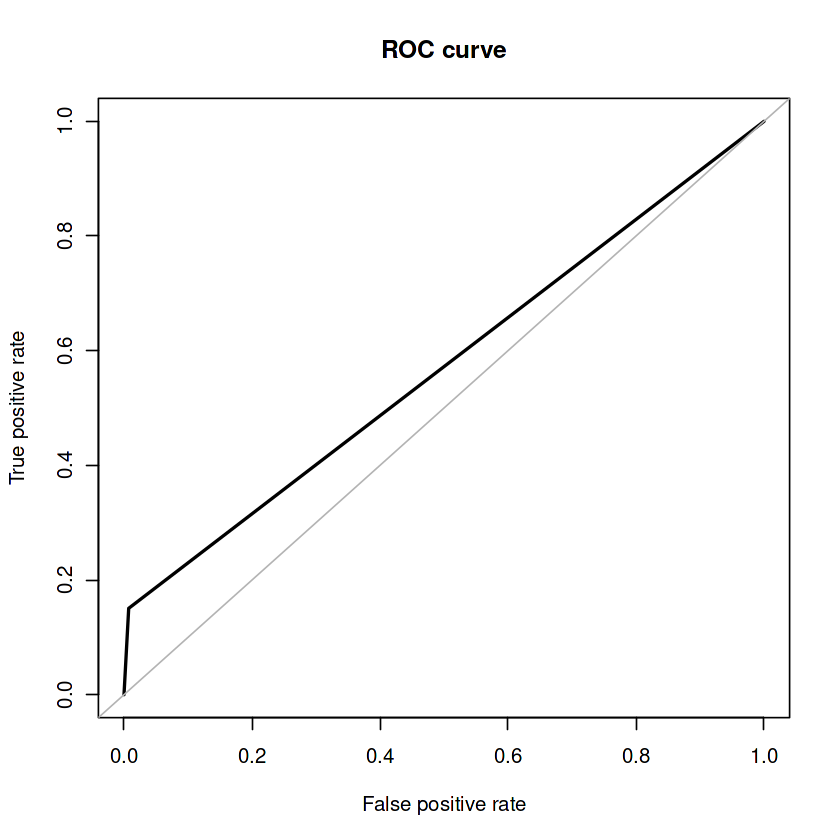

Area under the curve (AUC): 0.644

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1376  187
         1 1210  311
                                          
               Accuracy : 0.547           
                 95% CI : (0.5292, 0.5647)
    No Information Rate : 0.8385          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0856          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.6245          
            Specificity : 0.5321          
         Pos Pred Value : 0.2045          
         Neg Pred Value : 0.8804          
             Prevalence : 0.1615          
         Detection Rate : 0.1008          
   Detection Prevalence : 0.4932          
      Balanced Accuracy : 0.5783          
                                          
       'Positive' Class : 1               
                        

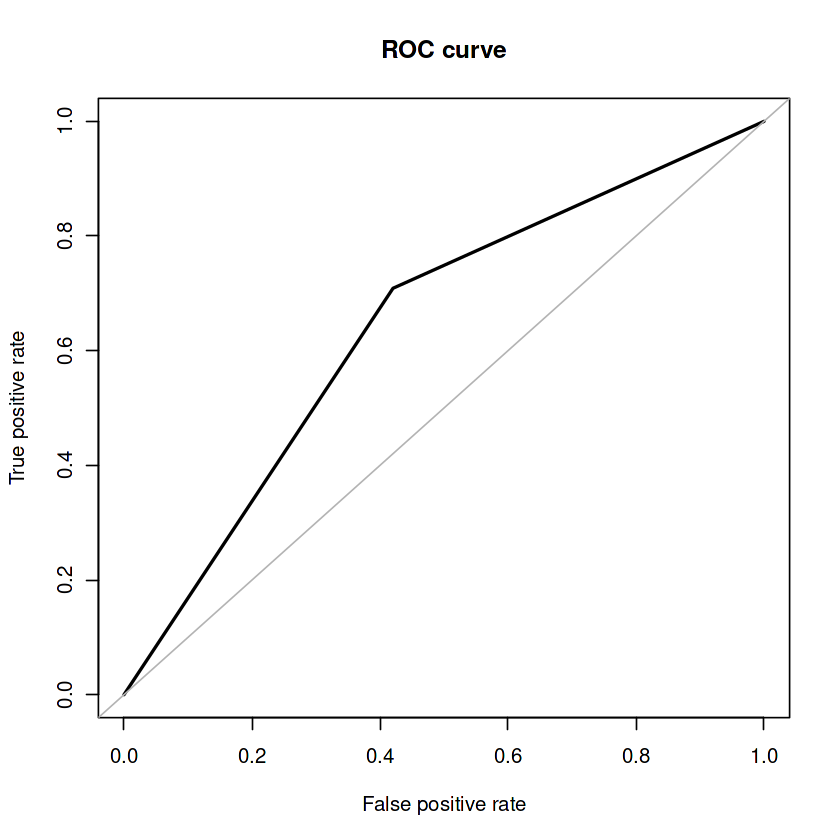

Area under the curve (AUC): 0.578

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1457  155
         1 1129  343
                                         
               Accuracy : 0.5837         
                 95% CI : (0.566, 0.6011)
    No Information Rate : 0.8385         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.1409         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.6888         
            Specificity : 0.5634         
         Pos Pred Value : 0.2330         
         Neg Pred Value : 0.9038         
             Prevalence : 0.1615         
         Detection Rate : 0.1112         
   Detection Prevalence : 0.4773         
      Balanced Accuracy : 0.6261         
                                         
       'Positive' Class : 1              
                                         

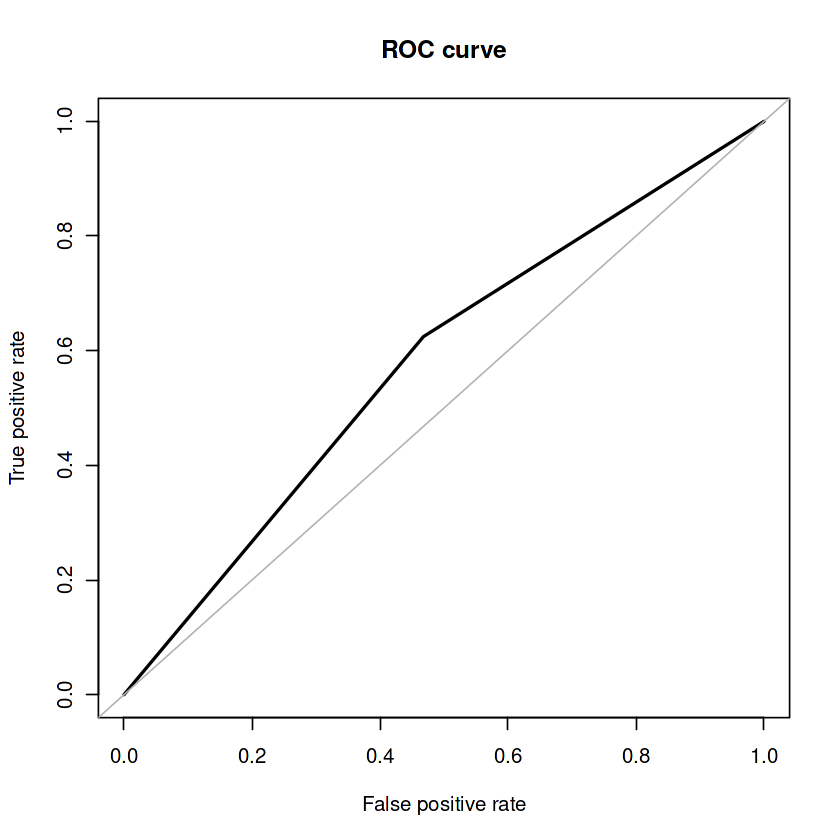

In [18]:
#STEP 6 TESTING MODEL PERFORMANCE, ALL MODELS WILL BE IN THE CORRESPONDING R CHUNKS

confusionMatrix(data = as.factor(canterra_data_1$pred), reference = as.factor(canterra_data_1$Attrition), positive = "1")

roc.curve(canterra_data_1$Attrition, canterra_data_1$pred)


###GOING TO SWITCH TO OTHER MODELS, THIS IS MODEL 2###

#table(test$Attrition, test$predicted_2)

confusionMatrix(data = as.factor(canterra_data_2$pred), reference = as.factor(canterra_data_2$Attrition), positive = "1")

roc.curve(canterra_data_2$Attrition, canterra_data_2$pred)


###MODEL 3###

confusionMatrix(data = as.factor(canterra_data_3$pred), reference = as.factor(canterra_data_3$Attrition), positive = "1")
roc.curve(canterra_data_3$Attrition, canterra_data_3$pred)

##MODEL 4##

confusionMatrix(data = as.factor(canterra_data_4$pred), reference = as.factor(canterra_data_4$Attrition), positive = "1")

In [19]:
#NOW DOING A STEPWISE REGRESSION, PAY ATTENTION TO STEP MODEL 4 BECAUSE IT GIVES US THE MOST IMPORTANT VARIABLES FROM A MGT PERSPECTIVE#

stepmodel_2 = step(Logistic_model_2, direction = "both")
formula(stepmodel_2)
summary(stepmodel_2)

stepmodel_3 = step(Logistic_model_3, direction = "both")
formula(stepmodel_3)
summary(stepmodel_3)

stepmodel_4 = step(Logistic_model_4, direction = "both")
formula(stepmodel_4) #THIS TELLS ME THAT THE MOST IMPORTANT VARIABLES ARE JOBSATISFACTION AND TOTALWORKINGYEARS
summary(stepmodel_4)

##MAKING PREDICTION MODEL FOR MODEL 4##
step_pred_2 = predict(object = stepmodel_2, newdata = train, type = "response")
head(step_pred_2)
summary(step_pred_2)
canterra_data_step2 = train
canterra_data_step2$pred = ifelse(step_pred_2 >= 0.5, 1, 0)

confusionMatrix(data = as.factor(canterra_data_step2$pred), reference = as.factor(canterra_data_step2$Attrition), positive = "1")

Start:  AIC=1284.68
Attrition ~ JobSatisfaction + TotalWorkingYears

                    Df Deviance    AIC
<none>                   1278.7 1284.7
- JobSatisfaction    1   1302.3 1306.3
- TotalWorkingYears  1   1341.9 1345.9


Attrition ~ JobSatisfaction + TotalWorkingYears


Call:
glm(formula = Attrition ~ JobSatisfaction + TotalWorkingYears, 
    family = binomial, data = data_balanced_under)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.684  -1.137   0.745   1.065   2.303  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        1.501239   0.200159   7.500 6.37e-14 ***
JobSatisfaction   -0.288243   0.059998  -4.804 1.55e-06 ***
TotalWorkingYears -0.073174   0.009836  -7.440 1.01e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1365.4  on 984  degrees of freedom
Residual deviance: 1278.7  on 982  degrees of freedom
AIC: 1284.7

Number of Fisher Scoring iterations: 4


Start:  AIC=1332.23
Attrition ~ Gender + Education + Age

            Df Deviance    AIC
- Education  4   1323.3 1329.3
- Gender     1   1319.9 1331.9
<none>           1318.2 1332.2
- Age        1   1359.3 1371.3

Step:  AIC=1329.35
Attrition ~ Gender + Age

            Df Deviance    AIC
- Gender     1   1324.5 1328.5
<none>           1323.3 1329.3
+ Education  4   1318.2 1332.2
- Age        1   1364.4 1368.4

Step:  AIC=1328.45
Attrition ~ Age

            Df Deviance    AIC
<none>           1324.5 1328.5
+ Gender     1   1323.3 1329.3
+ Education  4   1319.9 1331.9
- Age        1   1365.4 1367.4


Attrition ~ Age


Call:
glm(formula = Attrition ~ Age, family = binomial, data = data_balanced_under)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.5339  -1.1614   0.8588   1.1000   1.6081  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.608560   0.262342   6.132 8.70e-10 ***
Age         -0.044495   0.007149  -6.224 4.83e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1365.4  on 984  degrees of freedom
Residual deviance: 1324.5  on 983  degrees of freedom
AIC: 1328.5

Number of Fisher Scoring iterations: 4


Start:  AIC=1289.95
Attrition ~ Gender + Education + Age + JobSatisfaction + TotalWorkingYears

                    Df Deviance    AIC
- Education          4   1276.9 1286.9
- Age                1   1273.0 1289.0
- Gender             1   1273.5 1289.5
<none>                   1272.0 1290.0
- JobSatisfaction    1   1295.4 1311.4
- TotalWorkingYears  1   1297.3 1313.3

Step:  AIC=1286.87
Attrition ~ Gender + Age + JobSatisfaction + TotalWorkingYears

                    Df Deviance    AIC
- Age                1   1277.7 1285.7
- Gender             1   1277.9 1285.9
<none>                   1276.9 1286.9
+ Education          4   1272.0 1290.0
- JobSatisfaction    1   1299.1 1307.1
- TotalWorkingYears  1   1303.8 1311.8

Step:  AIC=1285.67
Attrition ~ Gender + JobSatisfaction + TotalWorkingYears

                    Df Deviance    AIC
- Gender             1   1278.7 1284.7
<none>                   1277.7 1285.7
+ Age                1   1276.9 1286.9
+ Education          4   1273.0 1289.0
-

Attrition ~ JobSatisfaction + TotalWorkingYears


Call:
glm(formula = Attrition ~ JobSatisfaction + TotalWorkingYears, 
    family = binomial, data = data_balanced_under)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.684  -1.137   0.745   1.065   2.303  

Coefficients:
                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)        1.501239   0.200159   7.500 6.37e-14 ***
JobSatisfaction   -0.288243   0.059998  -4.804 1.55e-06 ***
TotalWorkingYears -0.073174   0.009836  -7.440 1.01e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1365.4  on 984  degrees of freedom
Residual deviance: 1278.7  on 982  degrees of freedom
AIC: 1284.7

Number of Fisher Scoring iterations: 4


1         2         3         4         5         6 
0.5683429 0.6190949 0.6361939 0.6351625 0.2452474 0.5672499

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.07052 0.40422 0.49449 0.48097 0.58512 0.75765 

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1499  145
         1 1087  353
                                         
               Accuracy : 0.6005         
                 95% CI : (0.583, 0.6179)
    No Information Rate : 0.8385         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.1636         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.7088         
            Specificity : 0.5797         
         Pos Pred Value : 0.2451         
         Neg Pred Value : 0.9118         
             Prevalence : 0.1615         
         Detection Rate : 0.1145         
   Detection Prevalence : 0.4669         
      Balanced Accuracy : 0.6442         
                                         
       'Positive' Class : 1              
                                         

In [20]:
exp(coef(stepmodel_2))
exp(coef(stepmodel_3))

exp(coef(Logistic_model_2))
exp(coef(Logistic_model_3)) #as education increases in levels chances of attrition decrease

(Intercept)   JobSatisfaction TotalWorkingYears 
        4.4872444         0.7495795         0.9294390

(Intercept)         Age 
  4.9956145   0.9564804

(Intercept)   JobSatisfaction TotalWorkingYears 
        4.4872444         0.7495795         0.9294390

(Intercept)  GenderMale  Education2  Education3  Education4  Education5 
  4.9053456   1.1899674   1.2164958   0.8166207   0.8914171   0.9925960 
        Age 
  0.9561744

1 2 3 4 5 6 
0 1 1 0 1 0

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 675  69
         1 432 142
                                         
               Accuracy : 0.6199         
                 95% CI : (0.593, 0.6462)
    No Information Rate : 0.8399         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.1667         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.6730         
            Specificity : 0.6098         
         Pos Pred Value : 0.2474         
         Neg Pred Value : 0.9073         
             Prevalence : 0.1601         
         Detection Rate : 0.1077         
   Detection Prevalence : 0.4355         
      Balanced Accuracy : 0.6414         
                                         
       'Positive' Class : 1              
                                         

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 675  69
         1 432 142
                                         
               Accuracy : 0.6199         
                 95% CI : (0.593, 0.6462)
    No Information Rate : 0.8399         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.1667         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
            Sensitivity : 0.6730         
            Specificity : 0.6098         
         Pos Pred Value : 0.2474         
         Neg Pred Value : 0.9073         
             Prevalence : 0.1601         
         Detection Rate : 0.1077         
   Detection Prevalence : 0.4355         
      Balanced Accuracy : 0.6414         
                                         
       'Positive' Class : 1              
                                         

Area under the curve (AUC): 0.641

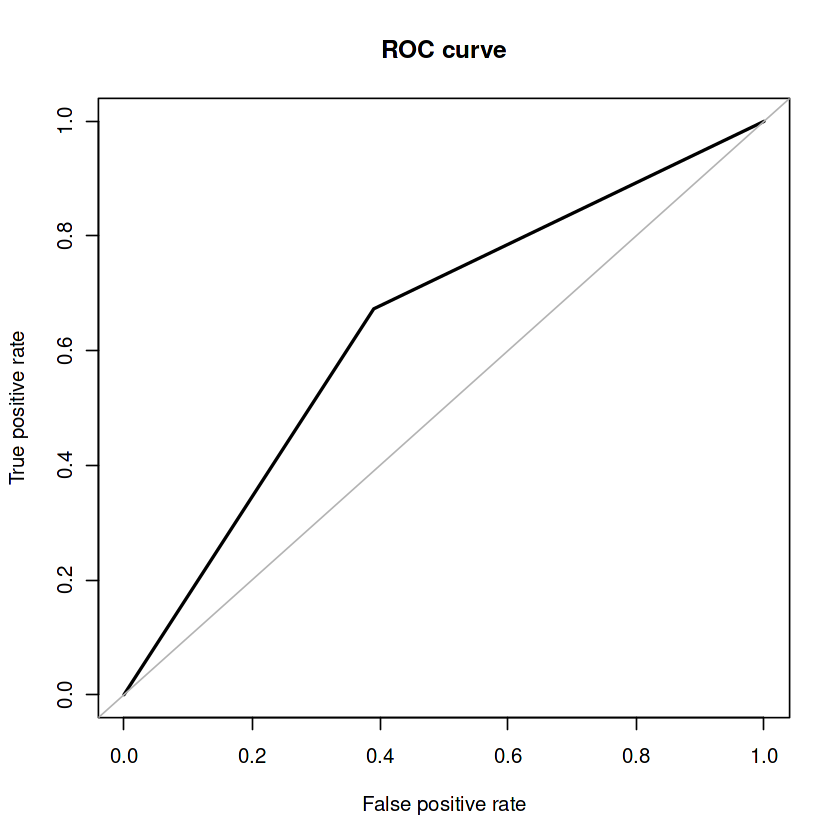

In [21]:
#USING MODEL 2 TO MAKE MY PREDICTIONS AGAINST TEST DATA#

testtesttest = predict(stepmodel_2, newdata = test, type = "response")
test$predicted = ifelse(testtesttest >= 0.50, 1, 0) #IF YOU MESS WITH THIS THRESHOLD THEN IT ACTUALLY WORKS ALOT BETTER!!!!
head(test$predicted)
confusionMatrix(data = as.factor(test$predicted), reference = as.factor(test$Attrition), positive = "1")
###ABOVE WAS BS TESTING AROUND###


final_test_pred = predict(Logistic_model_2, newdata = test, type = "response")
canterra_test_final = test
canterra_test_final$pred = ifelse(final_test_pred >= 0.5, 1, 0)

confusionMatrix(data = as.factor(canterra_test_final$pred), reference = as.factor(canterra_test_final$Attrition), positive = "1")

roc.curve(canterra_test_final$Attrition, canterra_test_final$pred)

In [22]:
library(ROCR)


Attaching package: ‘ROCR’


The following object is masked from ‘package:prediction’:

    prediction




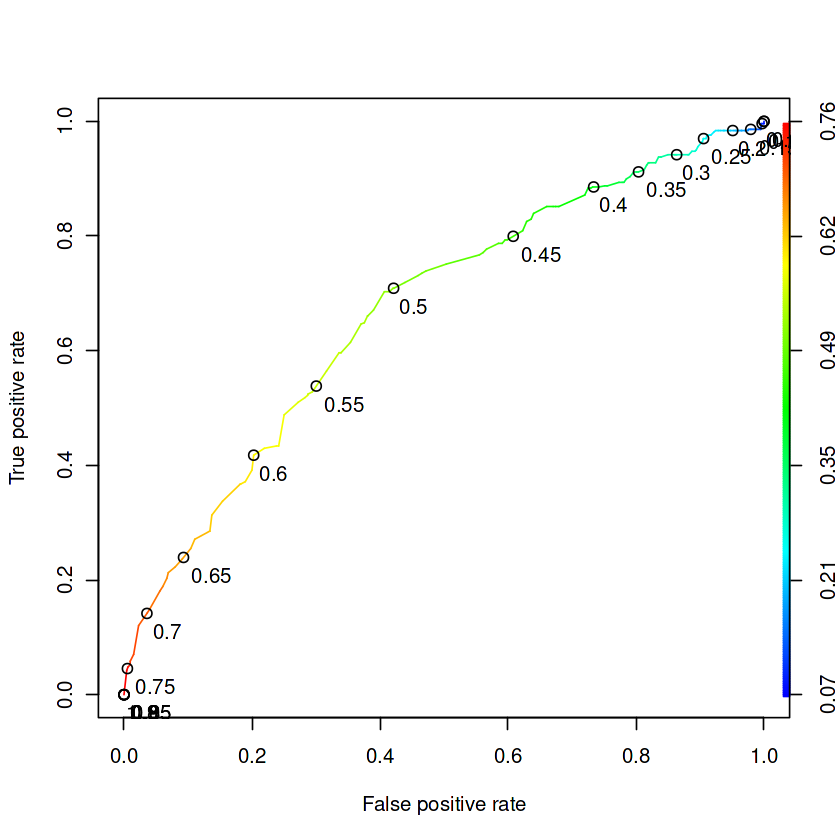

In [23]:
#TRAINING ROC CURVE COLOR GRAPHIC#
roc_pred = prediction(predictions = pred_2, labels = train$Attrition)
roc_perf = performance(roc_pred, "tpr", "fpr")

plot(roc_perf, 
     colorize = TRUE,
     print.cutoffs.at = seq(0, 1, 0.05),
     text.adj = c(-0.2, 1.7))